# CPPN Experiments

Compositional pattern-producing networks (CPPNs) are neural netwoks that map positions to outputs. When sampled across 2D or 3D spaces they can produce pixel or voxel patterns. They have been applied to a collaborate exploration process in the picbreeder system [1] and to soft robot evolution [2] among others. Most of the soft robotics evoltuion work I have seen uses them and they have relvannce to future work in evolutionary robotics. 


When I read Lipson’s Unshackling Evolution paper two figures (6 & 7) stood out to me.
<img src="imgs/indirect.png" alt="Drawing" style="width: 500px;"/>
<img src="imgs/direct.png" alt="Drawing" style="width: 250px;"/>

The direct encoding is criticized for “lack of regularity and organization.” However, my suspision is that both genotype methods had phenotype space biases and that perhaps CPPN’s bias may be more conducive to good robots. The 

Here, I wanted to evaluate CPPN and their biases as well as compare them to some ideas I had for modular-CPPNS.

1. sds
2. sdsad

In [ ]:
# ipython magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Python neat library
from neat.config import Config 
from neat import nn

# Source
from src import patterns, cppn
from src.plot import plot_fitnesses, plot_patterns, plot_best

# GA params
num_gens = 100
config = Config('config.txt')
config.report = False
config.pop_size = 50

We are going to test CPPNs abiltiy to match a certain target. Two target patterns are picked, one that is random and the other which is a repeating, ordered pattern. We will also explore how CPPN deal with scale.

In [ ]:
# GA metaparams
num_repeats = 5
dimensions = [16, 32, 64]
targets = [[patterns.random(d, d), patterns.checkerboard(d, d, 4)] for d in dimensions]

## View the objectives, one is random and the other ordered and repeating.

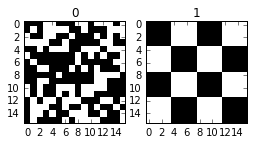

In [381]:
# The 16x16 pattern
plot_patterns(*targets[0])

## Evaluate the CPPN for each target and for each dimension

In [ ]:
# Store the best fitness and output from each run.
cppn_fitnesses = np.zeros((len(dimensions), 2, num_repeats, num_gens))
cppn_output = np.zeros((len(dimensions), 2, num_repeats), dtype=object)

for di in range(len(dimensions)):
    for ti, target in enumerate(targets[di]):
        for ri in range(num_repeats):
            stats, best_output = cppn.evolve_cppn(config, target, num_gens)
            cppn_fitnesses[di, ti, ri, :] = [c.fitness for c in stats.most_fit_genomes]
            cppn_output[di, ti, r=i] = best_output

## Plot evolution curves

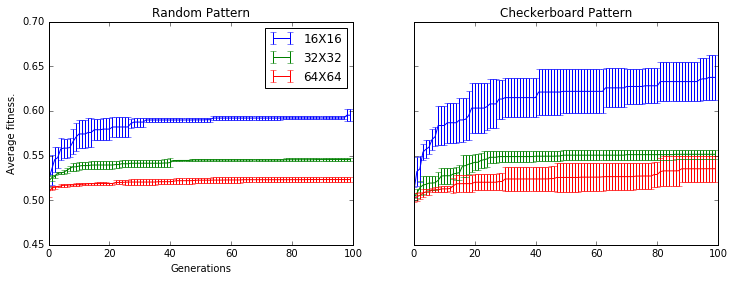

In [251]:
plot_fitnesses(cppn_fitnesses, dimensions, 'Standard CPPN')

It should be noted that a doing nothing gets a score of 0.5.

Avg Best Random Fitness: 0.595147058824
Avg Best Grid Fitness: 0.6375


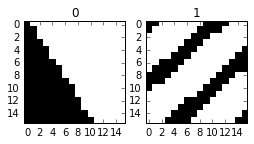

In [380]:
# Print best 16x16 targets
plot_best(cppn_fitnesses, cppn_outputs)

Diagonal stripes were a common motif in most CPPN checkerboard output. These stripes appear to be an early local minumum in the complexification process that the CPPN did not seem able to get out of. Theroretically the checkerboard should be a reasonable target as a function such as cos(x)*cos(y) and produces the right pattern type.

The random result is obiously very poor. It does not appear to have the resolution of individual pixels and so picks a segmens that is more right than wrong.

# Recurrent CPPN

In [ ]:
import copy
num_steps = [2, 4, 6]

recurrent_config = copy.deepcopy(config)
recurrent_config.input_nodes = 7
num_gens = 50 # These are much slower and we can usually see saturation by g=50

recurr_fitnesses = np.zeros((len(num_steps), 2, num_repeats, num_gens))
recurr_outputs = np.zeros((len(num_steps), 2, num_repeats), dtype=object)
recurr_genomes = np.zeros((len(num_steps), 2, num_repeats), dtype=object)

for si, s in enumerate(num_steps):
    for ti, target in enumerate(targets[0]):
        for ri in range(num_repeats):
            print(si, ti, ri)
            stats, best_output = cppn.evolve_recurrent_cppn(recurrent_config, target, s, num_gens)
            recurr_fitnesses[si, ti, ri, :] = [c.fitness for c in stats.most_fit_genomes]
            recurr_outputs[si, ti, ri] = best_output
            recurr_genomes[si, ti, ri] = stats.best_genome()

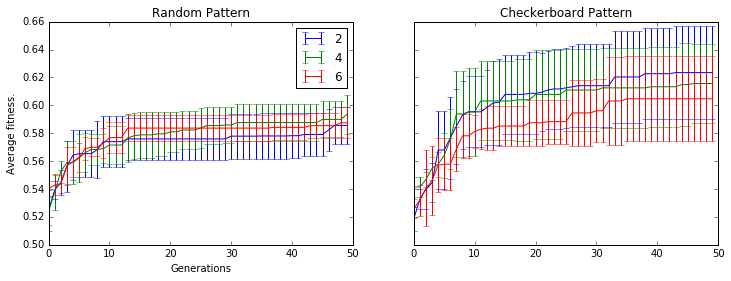

In [278]:
plot_fitnesses(recurr_fitnesses, num_steps, 'Recurrent CPPN')

Avg Best Random Fitness: 0.585591798695
Avg Best Grid Fitness: 0.6234375


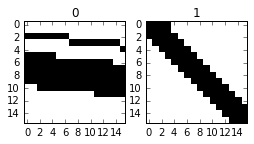

In [379]:
# Print best 2 step targets
plot_best(recurr_fitnesses, recurr_outputs, i=0)

Avg Best Random Fitness: 0.593445169307
Avg Best Grid Fitness: 0.615625


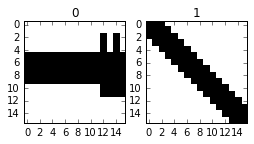

In [378]:
# Print best 4 step targets
plot_best(recurr_fitnesses, recurr_outputs, i=1)

Avg Best Random Fitness: 0.587474370923
Avg Best Grid Fitness: 0.6046875


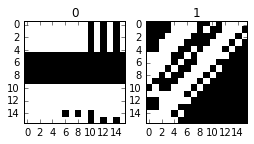

In [377]:
# Print best 6 step targets
plot_best(recurr_fitnesses, recurr_outputs, i=2)

## Display growth steps

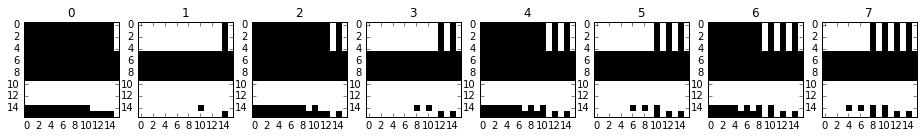

In [383]:
genome = recurr_genomes[2, 0, np.argmax(recurr_fitnesses[2, 0].max(axis=1))]
net = nn.create_feed_forward_phenotype(genome)
steps = list(cppn.express_recurrent_cppn(net, 16, 16, 8, yield_steps=True))
plot_patterns(*steps)

## Concluding Thoughts

The recurrent cppn idea does not demonstrate any promise. The patterns generated by Game of Life clear